In [1018]:
import numpy as np
import os
import random


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
from read_HiC import name_chromosomes
import seaborn as sns
from matplotlib.patches import Ellipse

import matplotlib.transforms as transforms

import sys
path=r'C:\Users\31649\Documents\genome analysis\genome_topology\functions'
sys.path.append(path)

from plotting_tools import set_layout
from statistical_analysis import comparison_distributions
from plotting_tools import save_figures

In [1019]:
#function to visualize confidence_ellipses on plots. Taken from the matplotlib documentation: 
#https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## PROCESS CT AND NETWORK PARAMETERS

Statistical analysis to extract any statistical difference between curaxin treated and control samples.
Pick resolution and quantile threshold for the analysis

In [1020]:
set_layout(18,18,18)

In [1021]:
quantile_thresh = 0.992
resolution = '160'
path_data = 'results counts'
path_figures = f'{path_data}/figures/{resolution}'

- Load processed data (data produced by ExtractTopology_Cyraxin notebook or curaxin_allres.py)
- Combine all data in one dataframe
- Add extra columns: normalized fractal dimension, entangled fraction

In [1022]:
control1 = pd.read_feather(f'{path_data}/processed_Control1_{resolution}_{quantile_thresh}.feather')
control1['Sample'] = ['Control 1']*len(control1)
control1['Specimen'] = ['Control']*len(control1)
control2 = pd.read_feather(f'{path_data}/processed_Control2_{resolution}_{quantile_thresh}.feather')
control2['Sample'] = ['Control 2']*len(control2)
control2['Specimen'] = ['Control']*len(control2)
treated1 = pd.read_feather(f'{path_data}/processed_Treated1_{resolution}_{quantile_thresh}.feather')
treated1['Sample'] = ['Treated 1']*len(treated1)
treated1['Specimen'] = ['Curaxin']*len(treated1)
treated2 = pd.read_feather(f'{path_data}/processed_Treated2_{resolution}_{quantile_thresh}.feather')
treated2['Sample'] = ['Treated 2']*len(treated2)
treated2['Specimen'] = ['Curaxin']*len(treated2)

frames = [control1, control2, treated1, treated2]
data = pd.concat(frames)

data['Norm dim'] = data['Fractal dimension']/data['N contacts']
data['Entangled fraction (%)'] = data['Cross (%)'] + data['Parallel (%)']

data = data.reset_index()

### Barplot
Pick the parameter you want to visualize, adjust y axis limits

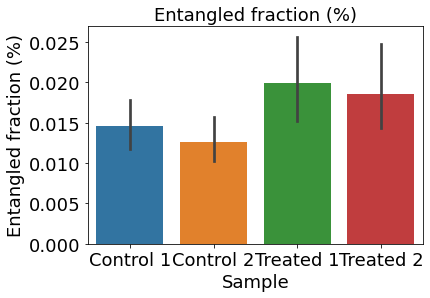

In [1023]:
parameter = 'Entangled fraction (%)'

a = plt.figure()
plt.title(parameter)
sns.barplot(x = 'Sample', y = parameter,data = data )
#plt.legend(bbox_to_anchor=(1, 1)) 
#plt.ylim(1.10, 1.2)

save_figures(plot = a,path = path_figures, name_file = parameter, method= quantile_thresh)

### Histplot
Pick the parameter you want to visualize, adjust binning

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


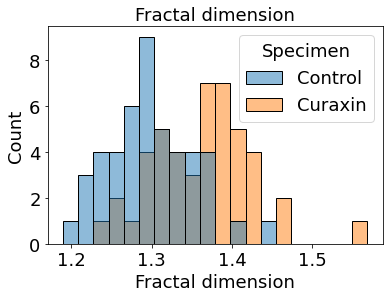

In [1024]:
a = plt.figure()
parameter = 'Fractal dimension'
plt.title(parameter)
sns.histplot( x= parameter, hue = 'Specimen', data = data, bins = 20, kde = False)
save_figures(plot = a,path = path_figures, name_file = f'dist_{parameter}', method= quantile_thresh)  

### Calculate p values associated to parameter distributions for the 4 samples
Choose the parameter you want to analyze

Control 1, Control 2
the distributions are not normal: 0.0003095081483479589, 0.00029694210388697684
The distributions have equal variance: 0.6296313310222712
Mannwhitneyu test: True = 0.18020633045640255
Control 1, Treated 1
the distributions are not normal: 0.0003095081483479589, 6.835028671048349e-06
The distributions have equal variance: 0.3255772479082174
Mannwhitneyu test: True = 0.09071713374520807
Control 1, Treated 2
the distributions are not normal: 0.0003095081483479589, 4.4293619794189e-06
The distributions have equal variance: 0.40613863633778147
Mannwhitneyu test: True = 0.18745316068649376
Control 2, Control 1
the distributions are not normal: 0.00029694210388697684, 0.0003095081483479589
The distributions have equal variance: 0.6296313310222712
Mannwhitneyu test: True = 0.18020633045640255
Control 2, Treated 1
the distributions are not normal: 0.00029694210388697684, 6.835028671048349e-06
The distributions have equal variance: 0.19215822930111062
Mannwhitneyu test: Fals

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


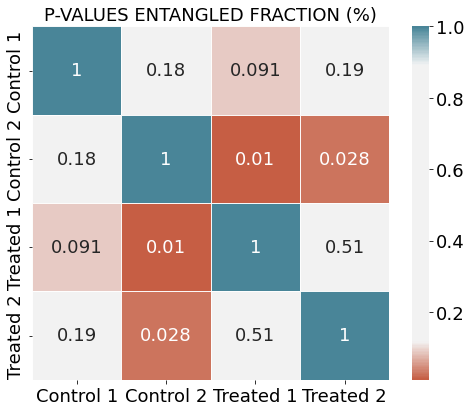

In [1025]:
quantity = 'Entangled fraction (%)'

samples = ['Control 1', 'Control 2', 'Treated 1', 'Treated 2']
p_values_matrix = np.ones((len(samples), len(samples)))
p_values = {}

for ind1, sample1 in enumerate(samples):
    for ind2, sample2 in enumerate(samples):
        if (sample1 != sample2):
            
            dist1 = data[data['Sample'] == sample1 ][quantity]
            dist2 = data[data['Sample'] == sample2 ][quantity]
            print(f'{sample1}, {sample2}')
            stats = comparison_distributions(dist1, dist2)
            p_value = float(stats[-1])
            key = tuple[sample1, sample2]
            p_values[key] = p_value
            p_values_matrix[ind1, ind2] = p_value
            
            
cmap = sns.diverging_palette(220, 20, sep=200, as_cmap=True).reversed()
label = []

a = plt.figure(figsize = (8, 6.5))
plt.title(f'P-values {quantity}'.upper())
sns.heatmap(p_values_matrix, xticklabels = samples, yticklabels = samples, annot = True, cmap = cmap, linewidths=1, 
            linecolor='white', alpha = 0.95)        
        
    
save_figures(plot = a,path = path_figures, name_file = f'p_values_{quantity}', method= quantile_thresh)    

## Barplot: chromosome hues
Visualize bar for each chromosome. Adjust y axis limits.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


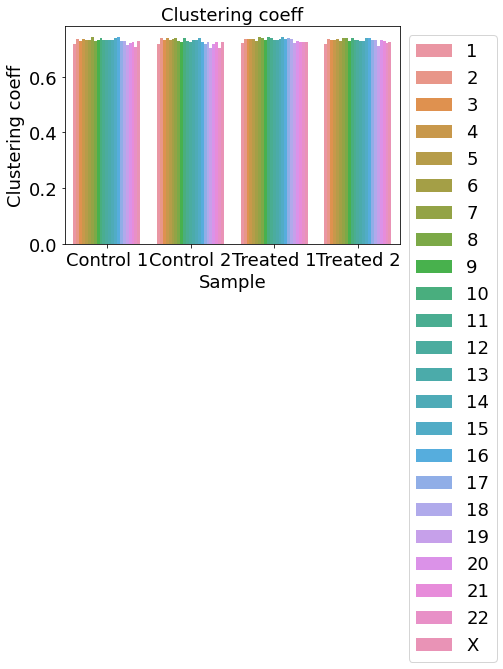

In [1026]:
parameter = 'Clustering coeff'
set_layout(18,18,18)
a = plt.figure()
sns.barplot(x = 'Sample', y = parameter, hue = 'Chromosome', data = data )
#plt.ylim(0.65, 0.78)
plt.title(parameter)
plt.legend(bbox_to_anchor=(1, 1))  
save_figures(plot = a,path = path_figures, name_file = f'chromosomes_{parameter}', method= quantile_thresh)  

### Scatterplot
Visualize each sample in the fractal dimension/ clustering coefficient plane

Text(0.5, 1.0, 'Higher order topological parameters')

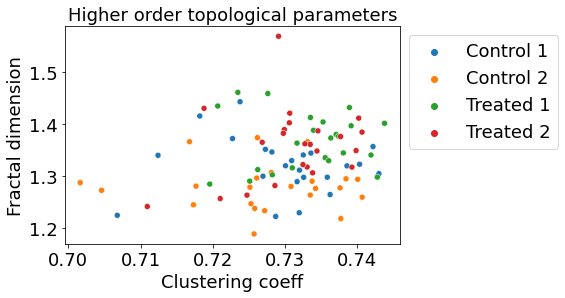

In [1027]:
plt.figure()
sns.scatterplot(x = 'Clustering coeff', y = 'Fractal dimension', hue = 'Sample', data = data)
plt.legend(bbox_to_anchor=(1, 1))  
plt.title('Higher order topological parameters')

### Scatterplot with confidence ellipses
Visualize control and curaxin samples separately


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


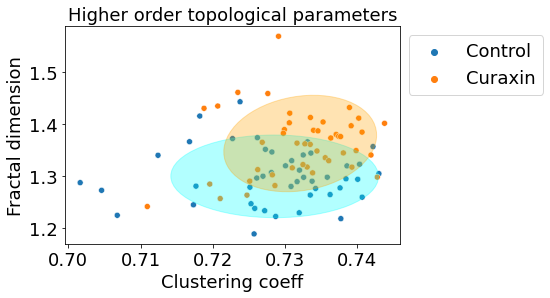

In [1028]:
fig, ax = plt.subplots()


parameter1 = 'Clustering coeff'
parameter2 = 'Fractal dimension'

plt.title('Higher order topological parameters')

sns.scatterplot(x = parameter1, y = parameter2, hue = 'Specimen', data = data, ax =ax)
plt.legend(bbox_to_anchor=(1, 1))  

x1 = data[data['Specimen'] == 'Control'][parameter1]
y1=  data[data['Specimen'] == 'Control'][parameter2]

confidence_ellipse(x1, y1, ax, n_std=1.5, facecolor='cyan',alpha=0.3, edgecolor='cyan')

x2 = data[data['Specimen'] == 'Curaxin'][parameter1]
y2=  data[data['Specimen'] == 'Curaxin'][parameter2]

confidence_ellipse(x2, y2, ax, n_std=1.5, facecolor='orange',alpha=0.3, edgecolor='orange')

save_figures(plot = fig,path = path_figures, name_file = f'{parameter1}_{parameter2}', method= quantile_thresh)  

## Groupings of chromosomes

Here we use groupings of chromosomes based on the barcode (Local matrix) analysis. Groupings are made based on the local distribution of the L patterns in the matrix, and whether this distribution changes in the curaxin treated samples. We see if different groups of chromosomes behave differently when treated with Curaxin, and to what extent.

- *grouping_maxima* indicates whether the chromosomes have the maximal length of L patterns in the first (1) or second (2) half.
- *grouping_minima* indicates whether the chromosomes have the minimal length og L patterns in the first (1) or second (2) half.
- *grouping_extra* indicates whether the chromosome minimal and maximal L pattern length changes half in the chromosome in the treated samples (with respect to the control). A change is indicated with an 'x', while '0' indicates the maxima/minima remain in the same half.

In [1029]:
#arrays for groupings:
grouping_maxima = [1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2]
grouping_minima = [1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2]
grouping_extra =  ['0', '0', 'x', 'x', '0', '0', '0', '0', '0', 'x', 'x', '0', 'x', '0', '0', 'x', '0', '0', '0', '0', '0', '0','x']

Insert grouping labels in the dataset

In [1030]:
grouping_maxima_array = grouping_maxima*4
grouping_minima_array = grouping_minima*4
groupingrouping_extra_array = grouping_extra*4

data['Minima'] = grouping_minima_array
data['Maxima'] = grouping_maxima_array 
data['Shift'] = groupingrouping_extra_array

Decide which grouping you want to analyze, and which parameter.

In [1035]:
grouping = 'Shift'
parameter = 'N contacts'
specimen = 'Control'

group_1 = data[data[grouping] == '0']
group_2 = data[data[grouping] == 'x']

dist1 = group_1[group_1['Specimen'] == specimen][parameter]
dist2 = group_2[group_2['Specimen'] == specimen][parameter]
stats = comparison_distributions(dist1, dist2)

The distributions are normal: 0.060287635773420334, 0.22516919672489166
The distributions have equal variance: 0.21091752036931918
Ttest: True = 0.31853803120576707


We find that Fractal dimension/Entangled fraction/Clustering coefficient differs between the X and 0 groups, when it comes to the conrol samples and those treated with curaxin, depending on the choice of cutoff and resolution. We plot the results in a boxplot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


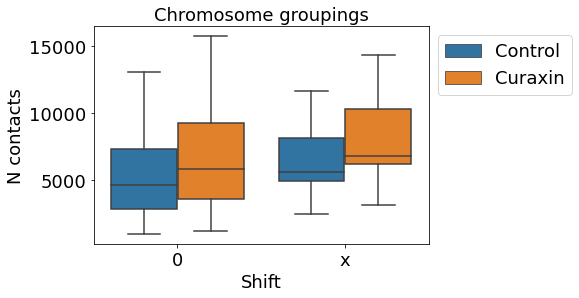

In [1033]:
fig = plt.figure()
plt.title('Chromosome groupings')
sns.boxplot(y = parameter, x = 'Shift', hue = 'Specimen', data = data)
plt.legend(bbox_to_anchor=(1, 1))  

save_figures(plot = fig,path = path_figures, name_file = f'{parameter}_grouping', method= quantile_thresh) 

Classification (ML)